In [1]:
#LSTM Optimisation Code
#Check for pytorch being installed
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No CUDA device")

2.3.0+cu121
True
1
NVIDIA GeForce GT 1030


In [2]:
#Libraries
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump, load
import random
import os
import datetime

In [3]:
#Optimisation Libraries
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import branin
import torch.optim as optim
from random import uniform

In [4]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)  # None means unlimited

In [5]:
#Code to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module.
    np.random.seed(seed_value)  # Numpy module.
    torch.manual_seed(seed_value)  # PyTorch to set the seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python software environment.

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # Sets the seed for generating random numbers for the current GPU.
        torch.cuda.manual_seed_all(seed_value)  # Sets the seed for generating random numbers on all GPUs.
        torch.backends.cudnn.deterministic = True  # Forces the use of the same algorithm
        torch.backends.cudnn.benchmark = False  #Helps when input sizes do not vary.


set_seed(42)

In [9]:
#Function to filter Data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [20]:
class CNN1D(nn.Module):
    def __init__(self, input_size, seq_length, num_filters, kernel_size, output_size, dropout):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout)
        self.flatten = nn.Flatten()
        
        # Calculate flattened size after conv and pooling
        conv_output_length = (seq_length - kernel_size + 1) // 2
        self.fc = nn.Linear(num_filters * conv_output_length, output_size)

    def forward(self, x):
        # Input x shape: (batch_size, seq_length, input_size)
        x = x.permute(0, 2, 1)  # (batch_size, input_size, seq_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, and MAPE given the true and predicted values.

    Args:
    y_true (torch.Tensor): True values.
    y_pred (torch.Tensor): Predicted values from the model.

    Returns:
    dict: Dictionary containing RMSE, MAE, and MAPE.
    """
    y_true = y_true.detach().numpy()  #y_true is a tensor, detach and convert to numpy
    y_pred = y_pred.detach().numpy()  #y_pred is a tensor, detach and convert to numpy

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation

    rmse = np.sqrt(mse)  # Calculate RMSE from MSE

    metrics = {
        "RMSE": rmse,
        "MSE":mse,
        "MAE": mae,
        "MAPE": mape
    }

    return metrics

In [7]:
#Function to create sequences. LSTM is a sequence based model. It takes sequences as an input and uses it to predict future values
def create_sequences(data, seq_length, date_times):
    xs = [] #Lists to store the input sequences
    ys = [] #Lists to store the target value sequences
    dates =[]   #List to store date sequences
    for i in range(len(data)-seq_length):       #Use the filtered values to create the sequences use on the model
        x = data.iloc[i:(i+seq_length)][['PM2.5_filtered', 'PM10_filtered']].values     #A slice of the dataframe (from i to i + length of the sequence) is taken to create an input sequence
        y = data.iloc[i+seq_length][['PM2.5_filtered', 'PM10_filtered']].values
        xs.append(x)
        ys.append(y)
        dates.append(date_times.iloc[i + seq_length])
    return np.array(xs), np.array(ys), np.array(dates)

In [10]:
#Input data
'''
Add input data
'''
data = pd.read_csv(r"C:\Users\User\Code\databook\data\US\CombinedData\USCleanedPMData.csv", parse_dates=['DateTime'])



data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #data clipped since PM data can never be negative

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for validation
EVEN_SPLIT = 0.0    #No testing is done


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)


# Split the full dataset into training and a temporary holding set for further splitting
x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization
# This can be done by re-indexing the training set with a permutation of indices
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

'''
# Further split the temporary dataset into validation and test sets
x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=TEST_SPLIT,    
    random_state=42,
    shuffle=False
)
'''

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
#test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


cuda


In [18]:
def train_small_cnn_with_hyperparams(params):
    """
    Train the CNN model with the given hyperparameters and return validation loss.
    """
    input_size = 2
    seq_length = 24
    output_size = 2

    # Extract hyperparameters
    num_filters = int(params['num_filters'])
    kernel_size = int(params['kernel_size'])
    dropout = params['dropout']
    learning_rate = params['learning_rate']

    # Define the model
    model = CNN1D(
        input_size=input_size,
        seq_length=seq_length,
        num_filters=num_filters,
        kernel_size=kernel_size,
        output_size=output_size,
        dropout=dropout
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()

    return val_loss / len(val_loader)

In [29]:
#Random Search Optimisation - Small Models
best_loss = float("inf")
best_params = None

# Store all losses to analyze variance
random_search_results = []

for i in range(50):
    params = {
        "num_filters": int(uniform(8, 64)),     # Number of filters
        "kernel_size": int(uniform(1, 3)),          # Filter width
        "learning_rate": round(uniform(1e-4, 1e-2), 5),
        "dropout": 0,     # Dropout rate
        #"weight_decay": 0,  # Round to 5 decimal places
    }

    val_loss = train_small_cnn_with_hyperparams(params)
    result = params.copy()
    result["val_loss"] = val_loss
    result["run"] = i + 1
    random_search_results.append(result)

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params

    print(f"Run number: {i+1} | Validation Loss: {val_loss}")
    print(f"Current best loss: {best_loss}")

# Compute overall stats
losses = [res["val_loss"] for res in random_search_results]
mean_loss = np.mean(losses)
std_dev_loss = np.std(losses)
variance_loss = np.var(losses)

print(f"\nMean Validation Loss: {mean_loss:.6f}")
print(f"Standard Deviation: {std_dev_loss:.6f}")
print(f"Variance: {variance_loss:.6f}")
print("Best  Validation Loss:", best_loss)
print(f"\nBest Parameters: {best_params}")

Run number: 1 | Validation Loss: 8.01860429567921e-05
Current best loss: 8.01860429567921e-05


c:\Users\User\Code\databook\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Run number: 2 | Validation Loss: 0.00010823601398794067
Current best loss: 8.01860429567921e-05
Run number: 3 | Validation Loss: 0.0007292584924977642
Current best loss: 8.01860429567921e-05
Run number: 4 | Validation Loss: 0.00017650009115285746
Current best loss: 8.01860429567921e-05
Run number: 5 | Validation Loss: 0.00011121542736949625
Current best loss: 8.01860429567921e-05
Run number: 6 | Validation Loss: 9.864954735355877e-05
Current best loss: 8.01860429567921e-05
Run number: 7 | Validation Loss: 0.0001348477956049897
Current best loss: 8.01860429567921e-05
Run number: 8 | Validation Loss: 0.00012070419644323274
Current best loss: 8.01860429567921e-05
Run number: 9 | Validation Loss: 0.0002863856114748263
Current best loss: 8.01860429567921e-05
Run number: 10 | Validation Loss: 0.00013013161022365372
Current best loss: 8.01860429567921e-05
Run number: 11 | Validation Loss: 0.00015154537848886072
Current best loss: 8.01860429567921e-05
Run number: 12 | Validation Loss: 7.121926

In [22]:
# Save results to CSV
# Get the current time
current_time = datetime.datetime.now().time()

TIME = current_time.strftime("%H-%M-%S")
results_df = pd.DataFrame(random_search_results)
results_df.to_csv(f"C:/Users/User/Lab/Global Air Pollution/Results/Opt/1DCNN_smallmodels_random_search_results_{TIME}.csv", index=False)
print("\nResults saved")


Results saved


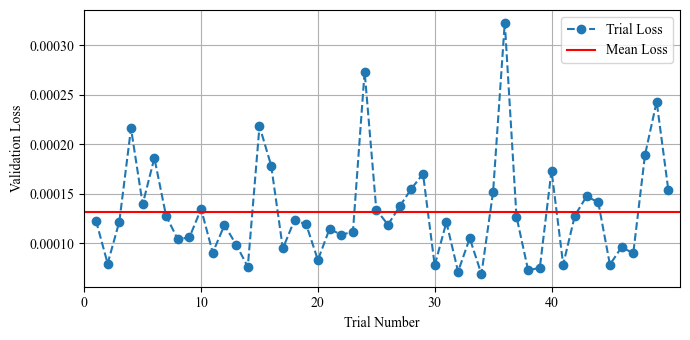

In [23]:
#Plot the graph
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(losses) + 1), losses, marker="o", linestyle="--", label="Trial Loss")
plt.axhline(y=mean_loss, color='r', linestyle='-', label="Mean Loss")
plt.xlabel("Trial Number",  fontsize=10 , fontname='Times New Roman')
plt.ylabel("Validation Loss",  fontsize=10 , fontname='Times New Roman')
plt.legend()
plt.xticks(np.arange(len(losses), step=10, dtype=int))
plt.xticks(rotation=0)
plt.xlim(0, len(losses)+1)

plt.grid()
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/Opt/1DCNN_Small_Models_Validation_Loss_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()

In [25]:
def train_complex_cnn_with_hyperparams(params):
    """
    Train the CNN model with the given hyperparameters and return validation loss.
    """
    input_size = 2
    seq_length = 24
    output_size = 2

    # Extract hyperparameters
    num_filters = int(params['num_filters'])
    kernel_size = int(params['kernel_size'])
    dropout = params['dropout']
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']

    # Define the model
    model = CNN1D(
        input_size=input_size,
        seq_length=seq_length,
        num_filters=num_filters,
        kernel_size=kernel_size,
        output_size=output_size,
        dropout=dropout
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    # Train
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()

    return val_loss / len(val_loader)

In [26]:
#Random Search Optimisation - Small Models
best_loss = float("inf")
best_params = None

# Store all losses to analyze variance
random_search_results = []

for i in range(50):
    params = {
        "num_filters": int(uniform(32, 128)),     # Number of filters
        "kernel_size": int(uniform(3, 6)),          # Filter width
        "learning_rate": round(uniform(1e-4, 1e-2), 5),
        "dropout": round(uniform(0.0, 0.5), 2),
        "weight_decay": round(uniform(1e-5, 1e-3), 5),  # Round to 5 decimal places
    }

    val_loss = train_complex_cnn_with_hyperparams(params)
    result = params.copy()
    result["val_loss"] = val_loss
    result["run"] = i + 1
    random_search_results.append(result)

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params

    print(f"Run number: {i+1} | Validation Loss: {val_loss}")
    print(f"Current best loss: {best_loss}")

# Compute overall stats
losses = [res["val_loss"] for res in random_search_results]
mean_loss = np.mean(losses)
std_dev_loss = np.std(losses)
variance_loss = np.var(losses)

print(f"\nMean Validation Loss: {mean_loss:.6f}")
print(f"Standard Deviation: {std_dev_loss:.6f}")
print(f"Variance: {variance_loss:.6f}")
print("Best  Validation Loss:", best_loss)
print(f"\nBest Parameters: {best_params}")

Run number: 1 | Validation Loss: 0.0017249290453180402
Current best loss: 0.0017249290453180402
Run number: 2 | Validation Loss: 0.0007798307780895034
Current best loss: 0.0007798307780895034
Run number: 3 | Validation Loss: 0.0007896361278601658
Current best loss: 0.0007798307780895034
Run number: 4 | Validation Loss: 0.0010931601195507627
Current best loss: 0.0007798307780895034
Run number: 5 | Validation Loss: 0.0020015692815162286
Current best loss: 0.0007798307780895034
Run number: 6 | Validation Loss: 0.0016641476293138722
Current best loss: 0.0007798307780895034
Run number: 7 | Validation Loss: 0.0008114703580582334
Current best loss: 0.0007798307780895034
Run number: 8 | Validation Loss: 0.0008031074008719169
Current best loss: 0.0007798307780895034
Run number: 9 | Validation Loss: 0.0010702042202906648
Current best loss: 0.0007798307780895034
Run number: 10 | Validation Loss: 0.0005660161778128371
Current best loss: 0.0005660161778128371
Run number: 11 | Validation Loss: 0.001

In [27]:
# Save results to CSV
# Get the current time
current_time = datetime.datetime.now().time()

TIME = current_time.strftime("%H-%M-%S")
results_df = pd.DataFrame(random_search_results)
results_df.to_csv(f"C:/Users/User/Lab/Global Air Pollution/Results/Opt/1DCNN_complexmodels_random_search_results_{TIME}.csv", index=False)
print("\nResults saved")


Results saved


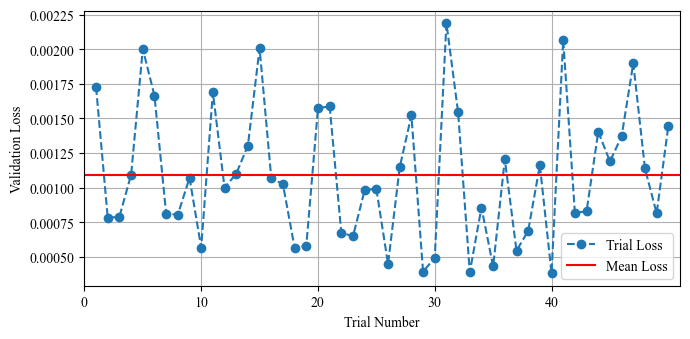

In [28]:
#Plot the graph
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(losses) + 1), losses, marker="o", linestyle="--", label="Trial Loss")
plt.axhline(y=mean_loss, color='r', linestyle='-', label="Mean Loss")
plt.xlabel("Trial Number",  fontsize=10 , fontname='Times New Roman')
plt.ylabel("Validation Loss",  fontsize=10 , fontname='Times New Roman')
plt.legend()
plt.xticks(np.arange(len(losses), step=10, dtype=int))
plt.xticks(rotation=0)
plt.xlim(0, len(losses)+1)

plt.grid()
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/Opt/1DCNN_Complex_Models_Validation_Loss_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()